In [1]:
import numpy as np 
import torch
import matplotlib.pyplot as plt
import matplotlib
from dataclasses import replace
import time
from datetime import datetime
import pandas as pd
import nlopt

In [2]:
import sys
sys.path.append('/home/gridsan/wmichaels/xray_coherence')

from src.simparams import SimParams
from src.threshold_opt import threshold_opt
from src.forwardmodels import forward_model_focus_plane_wave, forward_model_focus_plane_wave_power, forward_model_focus_plane_wave_overlap
from src.elements import ArbitraryElement, ZonePlate
from src.propagation import propagate_z
from src.sources import plane_wave
from src.inversedesign_utils import heaviside_projection, zp_init
from src.forwardmodels import propagate_z_arbg_z, field_z_arbg_z
from src.util import kramers_law_weights, create_material_map, refractive_index_at_wvl, spherize_1d_array

In [3]:
matplotlib.rcParams['figure.dpi'] = 140
matplotlib.rcParams.update({'font.size': 15})

In [4]:
def colors_list(N):
    cmap = plt.colormaps['viridis']
    colors = [cmap(x) for x in np.linspace(0, 1, N)]
    
    return colors

In [5]:
ID = 'standard2025-08-05 10.21.57'

In [6]:
dicts = np.load(f'/home/gridsan/wmichaels/opt_out/{ID}_dict.npy', allow_pickle=True)
xs = np.load(f'/home/gridsan/wmichaels/opt_out/{ID}_xs.npz', allow_pickle=True)
xs_full = np.load(f'/home/gridsan/wmichaels/opt_out/{ID}_x_fulls.npz', allow_pickle=True)
Is = np.load(f'/home/gridsan/wmichaels/opt_out/{ID}_Is.npz', allow_pickle=True)
objs = np.load(f'/home/gridsan/wmichaels/opt_out/{ID}_objs.npz', allow_pickle=True)
objs = np.array([float(objs[key]) for key in objs.files])

# Initial figure

This note book creates a comparison figure between a design from the standard dictionary, a random design, and a zone plate design. It also visualizes the center of the solution in 2D. Both of these subfigures are part of the first figure in the SM thesis proposal. 

In [7]:
dict_des = dicts[1]
x_des = xs["arr_1"]
x_full_des = xs_full["arr_1"]
I_des = Is["arr_1"]
obj_des = objs[1]

In [8]:
sim_params_std = dicts[1]["sim_params"]
opt_params_std = dicts[1]["opt_params"]
elem_params_std = dicts[1]["elem_params"]
args_std = dicts[1]["args"]

In [9]:
rand_x = torch.rand(sim_params_std.Nx // opt_params_std["n"] // 2)
rand_x_full = torch.repeat_interleave(
    torch.cat((rand_x, torch.flip(rand_x, dims=(0,)))).reshape(1, sim_params_std.Nx // opt_params_std["n"]), 
    opt_params_std["n"], 
    dim=1
)

rand_elem = ArbitraryElement(
    name = "rand_elem", 
    thickness = elem_params_std["thickness"], 
    elem_map = elem_params_std["elem_map"], 
    gap_map = elem_params_std["gap_map"], 
    x = rand_x
)

U_rand = field_z_arbg_z(
    x = rand_x_full, 
    sim_params = sim_params_std, 
    elem_params = elem_params_std, 
    z = args_std[-1]
    )

weights_std = sim_params_std.weights.view(-1, 1, 1)
    
I_rand = torch.sum((U_rand.abs()**2) * weights_std, dim=0).reshape(sim_params_std.Nx).detach().cpu().numpy()

In [10]:
zp_x = zp_init(
    lam = sim_params_std.lams[torch.argmax(sim_params_std.weights)], 
    f = args_std[-1], 
    min_feature_size = sim_params_std.dx * opt_params_std["n"], 
    sim_params = sim_params_std, 
    opt_params = opt_params_std
)

zp_x = torch.tensor(zp_x)

zp_x_full = torch.repeat_interleave(
    torch.cat((zp_x, torch.flip(zp_x, dims=(0,)))).reshape(1, sim_params_std.Nx // opt_params_std["n"]), 
    opt_params_std["n"], 
    dim=1
)

zp_elem = ArbitraryElement(
    name = "zp_elem", 
    thickness = elem_params_std["thickness"], 
    elem_map = elem_params_std["elem_map"], 
    gap_map = elem_params_std["gap_map"], 
    x = zp_x
)

U_zp = field_z_arbg_z(
    x = zp_x_full, 
    sim_params = sim_params_std, 
    elem_params = elem_params_std, 
    z = args_std[-1]
    )
    
I_zp = torch.sum((U_zp.abs()**2) * weights_std, dim=0).reshape(sim_params_std.Nx).detach().cpu().numpy()

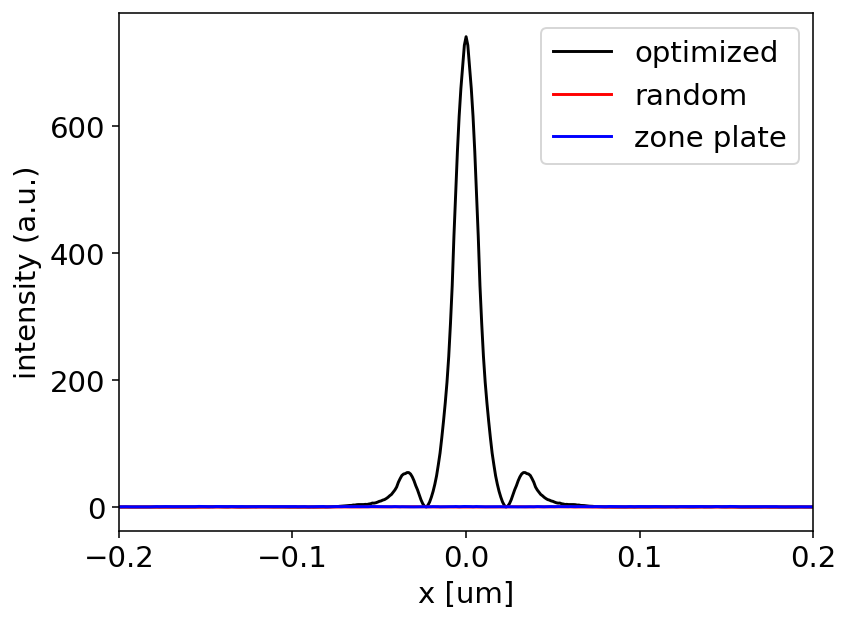

In [11]:
x_plot = sim_params_std.x.cpu() * 1e6

plt.plot(x_plot, I_des, color='black', label='optimized')
plt.plot(x_plot, I_rand, color='red', label='random')
plt.plot(x_plot, I_zp, color='blue', label='zone plate')
plt.xlabel('x [um]')
plt.ylabel('intensity (a.u.)')
plt.xlim([-0.2, 0.2])
# plt.ylim([0, 500])
plt.legend(loc='upper right')
plt.show()

In [99]:
ncrop = 5
ncut = 200
ncenter = x_full_des.shape[1]//2
design_2d = spherize_1d_array(x_full_des[:, ncenter:ncenter+ncut])
design_2d = design_2d[design_2d.shape[0]//ncrop:(ncrop-1)*design_2d.shape[0]//ncrop, design_2d.shape[1]//ncrop:(ncrop-1)*design_2d.shape[1]//ncrop]

In [100]:
design_2d.shape[1]

240

In [101]:
extent = design_2d.shape[1] * sim_params_std.dx / 2 * 1e6

In [102]:
extent

0.12000000000000001

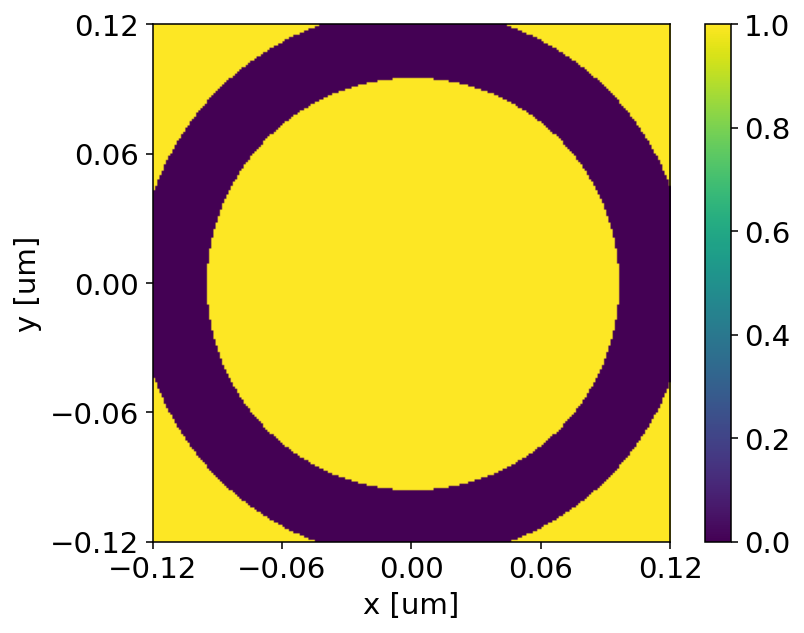

In [103]:
im = plt.imshow(design_2d, extent=[-extent, extent, -extent, extent])
plt.colorbar(im)
plt.xticks([-extent, -extent/2, 0, extent/2, extent])
plt.yticks([-extent, -extent/2, 0, extent/2, extent])
plt.xlabel("x [um]")
plt.ylabel("y [um]")
plt.show()

In [104]:
I_2d = spherize_1d_array(I_des[ncenter:ncenter+ncut])
I_2d = I_2d[I_2d.shape[0]//ncrop:(ncrop-1)*I_2d.shape[0]//ncrop, I_2d.shape[1]//ncrop:(ncrop-1)*I_2d.shape[1]//ncrop]

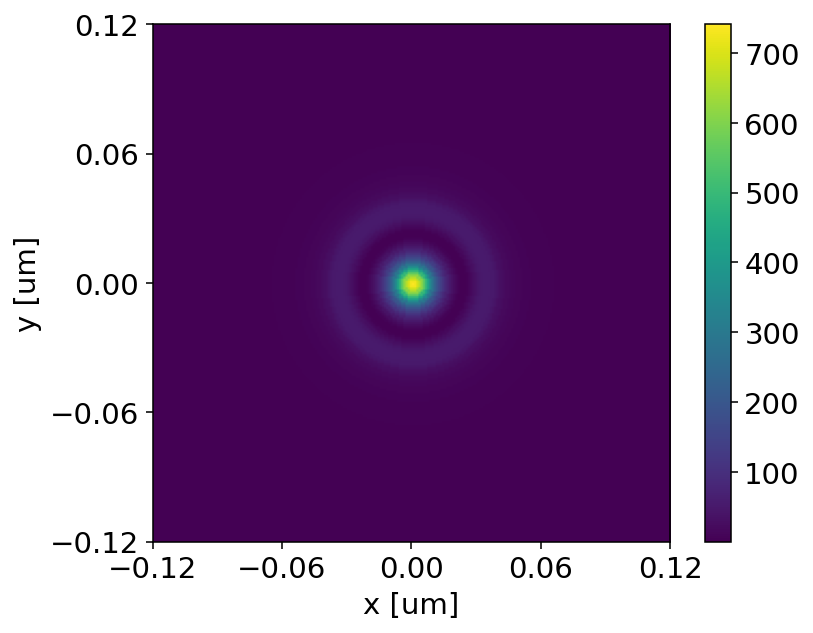

In [105]:
image = plt.imshow(I_2d, extent=[-extent, extent, -extent, extent])
plt.colorbar(image)
plt.xticks([-extent, -extent/2, 0, extent/2, extent])
plt.yticks([-extent, -extent/2, 0, extent/2, extent])
plt.xlabel("x [um]")
plt.ylabel("y [um]")
plt.show()